# import packages.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Read input data

In [2]:
train_data = pd.read_csv('~/input/titanic/train.csv')
test_data = pd.read_csv('~/input/titanic/test.csv')

train_data['Test'] = 0
test_data['Test'] = 1

all_data = pd.concat([train_data, test_data], ignore_index=True)

# Process data

## Preprocess

In [3]:
def preprocess_pclass(df):
    pass

def preprocess_name(df):
    # Extract the character string corresponding to "~~." from Name.
    df["Title"] = df['Name'].str.extract("([A-Za-z]+)\.")
    pd.crosstab(df['Title'], [df['Sex'], df['Pclass']])
    
    # Group into representative titles
    df['Title'] = df['Title'].replace(['Countess', 'Lady', 'Major', 'Sir'], 'Upper')
    df['Title'] = df['Title'].replace(['Capt', 'Col', 'Don', 'Dona', 'Jonkheer', 'Rev' ], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace(['Mme'], 'Mrs')
    
def preprocess_sex(df):
    df['Sex'] = df['Sex'].replace({'male':0, 'female': 1})
    
def preprocess_age(df):

    def generations(age):
        if age <= 6: return 0
        if age <= 18: return 1
        if age <= 60: return 2
        return 3
    
    df['Generation'] = df['Age'].map(lambda age : generations(age))
    
def preprocess_sibsp_parch(df):
    df['FamilySize'] = df['SibSp'] + df['Parch']
    df['IsAlone'] = df['FamilySize'].map(lambda fsize : 1 if fsize==0 else 0)

def preprocess_ticket(df):
    pass

def preprocess_fare(df):
    
    def fare_range(fare):
        if fare < 5: return 0
        if fare < 10: return 1
        if fare < 15: return 2
        if fare < 20: return 3
        if fare < 50: return 4
        return 5

    df['FareRange'] = df['Fare'].map(lambda fare : fare_range(fare))

def preprocess_cabin(df):
    df["HasCabin"] = df['Cabin'].map(lambda cabin : 0 if type(cabin)==float else 1)

def preprocess_embarked(df):
    df['Embarked'] = df['Embarked'] .replace({'S':0, 'Q': 1, 'C': 2})

def preprocess_all_features(df):
    preprocess_pclass(df)
    preprocess_name(df)
    preprocess_sex(df)
    preprocess_age(df)
    preprocess_sibsp_parch(df)
    preprocess_ticket(df)
    preprocess_fare(df)
    preprocess_cabin(df)
    preprocess_embarked(df)
    
preprocess_all_features(all_data)

## Fill NaN

In [4]:
def fillna_age(df):
    df['Age'] = df.groupby(['Title'])['Age'].apply(lambda age: age.fillna(age.dropna().median()))
    
    titles = df['Title'].unique()
    for title in titles:
        title_df = df[df['Title']==title]
        median_age = title_df['Age'].dropna().median()
        #print(title, median_age)

def fillna_fare(df):
    df['Fare'] = df.groupby(['Title'])['Fare'].apply(lambda fare: fare.fillna(fare.dropna().median()))
    
    titles = df['Title'].unique()
    for title in titles:
        title_df = df[df['Title']==title]
        median_fare = title_df['Fare'].dropna().median()
        #print(title, median_fare)

def fillna_embarked(df):
    mode = df['Embarked'].mode()[0]
    df['Embarked'].fillna(mode, inplace=True)
    df = df.astype({'Embarked': int})

def fillna_all(df):
    fillna_age(df)
    preprocess_age(df)
    fillna_fare(df)
    preprocess_fare(df)
    fillna_embarked(df)
    
fillna_all(all_data)

## Create new features

### Create FamilyDeath

In [5]:
def create_family_death(df):
    df['LastName'] = df['Name'] .map(lambda name: name.split(",")[0])

    df['FamilyDeath'] = np.nan
    col_no = df.columns.get_loc('FamilyDeath')

    for i in range(len(df)):

        if df.iloc[i]['FamilySize'] > 0: 
            
            last_name = df.iloc[i]['LastName']
            family_size = df.iloc[i]['FamilySize']
            
            # Extract data of family members except yourself
            temp = pd.concat([df.iloc[:i], df.iloc[i+1:]])
            family = temp[(temp['LastName'] == last_name) & (temp['FamilySize'] == family_size)]
            
            if len(family) == 0:
                continue
                
            # Set the average of the survival rate of the family excluding yourself
            df.iloc[i, col_no] = family.Survived.mean()
        
    #df['FamilyDeath'] = df.groupby(['Title'])['FamilyDeath'].apply(lambda fd: fd.fillna(fd.dropna().mean()))
    df['FamilyDeath'] .fillna(0.5, inplace=True)

create_family_death(all_data)

## Convert categorical variables to scalar variables

In [6]:
def convert_title_to_scalar(df):
    df['TitleNumber'] = 0
    
    temp = df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived')#, ascending=False)
    temp['TitleNumber'] = np.arange(len(temp))
    
    for i in range(len(temp)):
        title = temp.iloc[i]['Title']
        number = temp.iloc[i]['TitleNumber']
        df.loc[df['Title'] == title, 'TitleNumber'] = number

convert_title_to_scalar(all_data)

## Visualize the relationship between features and survival rate

In [7]:
train_all = all_data[all_data['Test'] == 0]
test_all = all_data[all_data['Test'] == 1]

In [8]:
train_all[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Survived
6,Upper,0.800000
4,Mrs,0.793651
2,Miss,0.702703
1,Master,0.575000
0,Dr,0.428571
3,Mr,0.156673
5,Rare,0.090909


In [9]:
train_all[['Generation', 'Survived']].groupby(['Generation'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Generation,Survived
0,0,0.686275
1,1,0.402174
2,2,0.365014
3,3,0.227273


In [10]:
train_all[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


In [11]:
train_all[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [12]:
train_all[['FareRange', 'Survived']].groupby(['FareRange'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FareRange,Survived
5,5,0.677019
3,3,0.500000
4,4,0.418605
2,2,0.388430
1,1,0.206250
0,0,0.062500


In [13]:
train_all[['HasCabin', 'Survived']].groupby(['HasCabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,HasCabin,Survived
1,1,0.666667
0,0,0.299854


In [14]:
train_all[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
2,2.0,0.553571
1,1.0,0.389610
0,0.0,0.339009


In [15]:
train_all[['FamilyDeath', 'Survived']].groupby(['FamilyDeath'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilyDeath,Survived
2,0.333333,1.000000
4,0.666667,0.750000
5,1.000000,0.682692
3,0.500000,0.360606
0,0.000000,0.227273
1,0.142857,0.000000


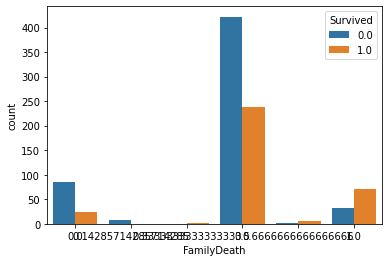

In [16]:
sns.countplot(x='FamilyDeath', data=train_all, hue='Survived')

In [17]:
train_all[['TitleNumber', 'Survived']].groupby(['TitleNumber'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,TitleNumber,Survived
6,6,0.800000
5,5,0.793651
4,4,0.702703
3,3,0.575000
2,2,0.428571
1,1,0.156673
0,0,0.090909


# Trainning

## Remove unnecessary features

In [18]:
drop_columns = ['Name', 'Age', 'SibSp', 'Parch', 'Fare', 'Ticket', 'Cabin', 'Title', 'LastName']

all_data.drop(columns=drop_columns, inplace=True)
all_data.head()

,PassengerId,Survived,Pclass,Sex,Embarked,Test,Generation,FamilySize,IsAlone,FareRange,HasCabin,FamilyDeath,TitleNumber
0,1,0.0,3,0,0.0,0,2,1,0,1,0,0.0,1
1,2,1.0,1,1,2.0,0,2,1,0,5,1,0.5,5
2,3,1.0,3,1,0.0,0,2,0,1,1,0,0.5,4
3,4,1.0,1,1,0.0,0,2,1,0,5,1,0.0,5
4,5,0.0,3,0,0.0,0,2,0,1,1,0,0.5,1


## Evaluation 1st.

In [19]:
test_group = all_data.groupby('Test')

train_y = test_group.get_group(0)['Survived']
train_y = train_y.astype({'Survived': int})

train_x = test_group.get_group(0).drop(columns=['Test', 'Survived'])
test_x = test_group.get_group(1).drop(columns=['Test', 'Survived'])

Score:0.8373


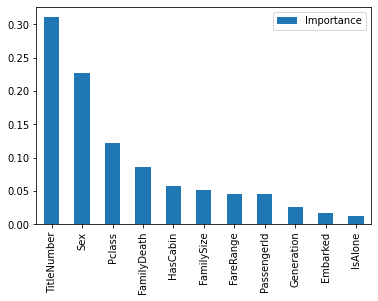

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

# Trainning with cross validation and and score calculation
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
result = cross_val_score(model, train_x, train_y, cv=kf, scoring='accuracy')
print('Score:{0:.4f}'.format(result.mean()))

# Evaluation of features
#model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(train_x, train_y)

importances = model.feature_importances_
columns = train_x.columns

feature_importances = pd.DataFrame(importances, index=train_x.columns, columns=['Importance'])
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances.plot.bar()

## Remove invalid features

In [21]:
drop_columns = ['PassengerId', 'Generation', 'Embarked', 'IsAlone']

all_data.drop(columns=drop_columns, inplace=True)
all_data.head()

,Survived,Pclass,Sex,Test,FamilySize,FareRange,HasCabin,FamilyDeath,TitleNumber
0,0.0,3,0,0,1,1,0,0.0,1
1,1.0,1,1,0,1,5,1,0.5,5
2,1.0,3,1,0,0,1,0,0.5,4
3,1.0,1,1,0,1,5,1,0.0,5
4,0.0,3,0,0,0,1,0,0.5,1


## Evaluation 2nd.

In [22]:
test_group = all_data.groupby('Test')

train_y = test_group.get_group(0)['Survived']
train_y = train_y.astype({'Survived': int})

train_x = test_group.get_group(0).drop(columns=['Test', 'Survived'])
test_x = test_group.get_group(1).drop(columns=['Test', 'Survived'])

Score:0.8429


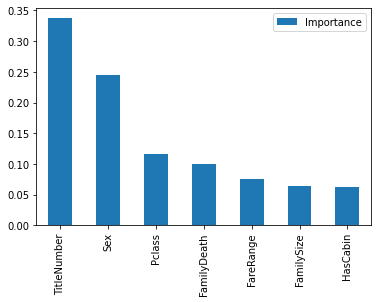

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

# Trainning with cross validation and and score calculation
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
result = cross_val_score(model, train_x, train_y, cv=kf, scoring='accuracy')
print('Score:{0:.4f}'.format(result.mean()))

# Evaluation of features
#model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(train_x, train_y)

importances = model.feature_importances_
columns = train_x.columns

feature_importances = pd.DataFrame(importances, index=train_x.columns, columns=['Importance'])
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances.plot.bar()

# Output submission file

In [24]:
# Prediction
predictions = model.predict(test_x)

# Output result to csv.
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)